## Assignment Details

A travel insurance is a policy purchased by travelers to cover any loss arising while travelling including but not limited to baggage claim, delay in flight, accident suffered etc. Instead of paying out of pocket for travel related accidents, people pay annual premiums to a travel insurance company; the company then pays all or most of the costs associated with the travel accident or any other loss suffered. Fraud Detection is one the important use cases of Data science in Insurance Industry. Develop a predictive model that predicts if a travel insurance claim is fraudulent or not. This task is designed to test your ability to understand and evaluate business use cases from given data source along with the scripting skills, your knowledge of data science techniques, your ability to work effectively, efficiently, and independently within a commercial setting. 
 

·         Deliverables:

o   Jupyter notebook of your solution including EDA, feature engineering, any assumptions made, model building and hyper parameter tuning

o   Presentation/pdf for your solution.


In [1]:
#Import the necessary packages
import pandas as pd
import numpy as np

from collections import Counter

import os
import sys

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix as CM, roc_curve, roc_auc_score
from sklearn import svm

#Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV as GCV
from sklearn.model_selection import RandomizedSearchCV as RSCV

#Import utility functions
import UtilityFunctions as UF
import WOE_IV as woe

In [2]:
#Read the train and test data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


In [3]:
#Dimensions of the data
print("Train Data Dimensions:- {}" .format(train_data.shape))
print("Test Data Dimensions:- {}" .format(test_data.shape))

Train Data Dimensions:- (52310, 11)
Test Data Dimensions:- (22421, 10)


In [4]:
#Event rate of the Target
def get_frequency_dist(cat_var, data=train_data):
    count = dict(Counter(data[cat_var]))
    
    count_df = pd.DataFrame({'Categories': list(count.keys()),\
                             'Counts': count.values()},\
                           columns=['Categories', 'Counts'])
    
    #Sort in descending order of count
    count_df = count_df.sort_values(by='Counts', ascending=False)
    
    #Obtain the % Counts
    total_count = sum(count_df['Counts'])
    count_df['Counts_%'] = count_df['Counts']*100/total_count #Broadcasting
    
    return count_df

#Target Event rate of train data
print("Train Data Target Distribution:- \n{}\n" .format(get_frequency_dist('Claim')))

#print("Test Data Target Distribution:- \n{}" .format(get_frequency_dist('Claim', test_data)))

Train Data Target Distribution:- 
   Categories  Counts   Counts_%
0           0   43590  83.330147
1           1    8720  16.669853



In [5]:
#Check whether all the IDs are unique
len(set(train_data['ID'])) == train_data['ID'].shape[0]

False

In [6]:
#Descriptive Statistics
#Get the descriptive statistics of the data
stats_obj_train = UF.GetStats(train_data)

data_stats_train = stats_obj_train.driver()

#Write the statistics to a file
data_stats_train.to_csv("train_data_stats.csv")

data_stats_train

,Features,Missing Value Count,Missing Value Percentage,Data Types,count,mean,std,min,25%,50%,75%,max,Unique Categories
0,ID,0,0.0,Integer,52310.0,6005.745804,2306.450475,2000.0,4015.0,6002.0,8004.00,10000.00,NaN
1,Agency,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
2,Agency Type,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,Distribution Channel,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,Product Name,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
5,Duration,0,0.0,Integer,52310.0,58.256108,109.138708,-2.0,10.0,24.0,57.00,4881.00,NaN
6,Destination,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0
7,Net Sales,0,0.0,Float,52310.0,48.554673,60.198589,-389.0,19.8,29.5,55.00,682.00,NaN
8,Commision (in value),0,0.0,Float,52310.0,12.219963,22.847645,0.0,0.0,0.0,13.38,262.76,NaN
9,Age,0,0.0,Integer,52310.0,39.555725,13.762473,0.0,33.0,36.0,43.00,118.00,NaN


In [7]:
#Get the descriptive statistics of the data
stats_obj_test = UF.GetStats(test_data)

data_stats_test = stats_obj_test.driver()

#Write the statistics to a file
data_stats_test.to_csv("test_data_stats.csv")

data_stats_test

,Features,Missing Value Count,Missing Value Percentage,Data Types,count,mean,std,min,25%,50%,75%,max,Unique Categories
0,ID,0,0.0,Integer,22421.0,15499.196646,2606.751171,11000.0,13236.0,15515.000000,17762.00,20000.0,NaN
1,Agency,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
2,Agency Type,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,Distribution Channel,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,Product Name,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0
5,Duration,0,0.0,Integer,22421.0,59.100665,114.819397,-1.0,10.0,24.000000,58.00,4857.0,NaN
6,Destination,0,0.0,Categorical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0
7,Net Sales,0,0.0,Float,22421.0,49.446070,61.794609,-297.0,19.8,29.518868,56.00,810.0,NaN
8,Commision (in value),0,0.0,Float,22421.0,12.316924,22.957306,0.0,0.0,0.000000,13.63,283.5,NaN
9,Age,0,0.0,Integer,22421.0,39.784889,13.910773,1.0,34.0,36.000000,43.00,118.0,NaN


## Plotting

Box plots of the continuous variables will bw used for vizualizing the outlies

continuos variables = ['Duration', 'Net Sales', 'Commision (in value)', 'Age']


In [8]:
#Univariate
#Box Plots

def box_plot(cont_var, data=train_data):
    '''
    Vizualize outlies via IQR(Q3-Q1)
    '''
    plt.boxplot(data[cont_var])
    plt.title(cont_var + " Box Plot")
    
    plt.show() #This should be before saving the figure
    plt.savefig(os.getcwd() + '/Plots/Box Plots/' + cont_var + "_IQR.png")
    
def outlier_wrt_SD(cont_var, data=train_data):
    '''
    Calculate Outliers using SD
    '''
    #sd = 
    pass



In [9]:
#Bi-Variate Plots
def seperability_plot(var_1, var_2, data=train_data, target='Claim'):
    '''
    Plot continuous variables and Target
    X-axis:- First continuous variable
    Y-axis:- Second continuous variable
    Return:-
    A plot that checks how the target is distributed and can the classes be seperated
    '''
    #Create a new column with the tags assigned to 0 and 1
    data[target + '_tagged'] = data[target].map({0:'Genuine Claim', 1:'Fraud Claim'})
    targets = ['Genuine Claim', 'Fraud Claim']
    
    for label in targets:
        x = data.loc[data[target + '_tagged']==label, var_1]
        y = data.loc[data[target + '_tagged']==label, var_2]
        
        plt.scatter(x, y)
        
    if(target + '_tagged' in data.columns):
        data = data.drop(target + '_tagged', axis=1)
    
    #Assign class labels to the plotted points    
    plt.legend(targets)
    
    #plt.title(var_1 + " V/S " + var_2)
    plt.xlabel(var_1)
    plt.ylabel(var_2)
    
    plt.savefig(os.getcwd() + '/Plots/Bi-Variate/' + var_1 + " VS " + var_2 + ".jpg")
    plt.show()

In [10]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label st

## Continuous Variables

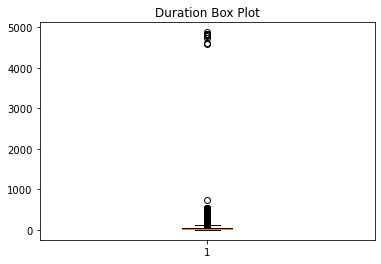

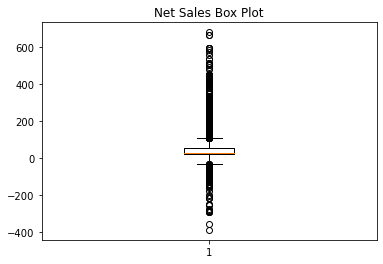

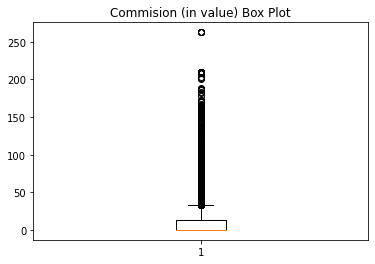

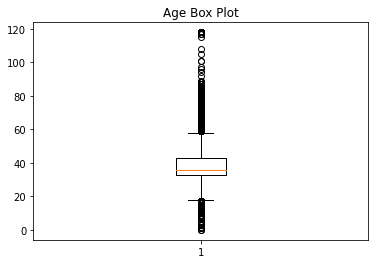

[None, None, None, None]

<Figure size 432x288 with 0 Axes>

In [11]:
continuous_vars =  ['Duration', 'Net Sales', 'Commision (in value)', 'Age']
list(map(box_plot, continuous_vars))

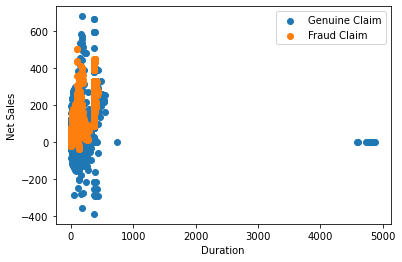

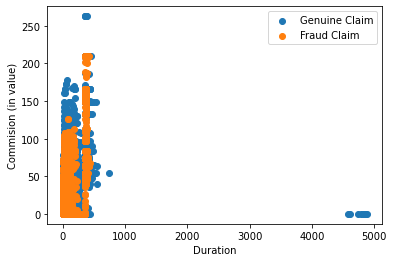

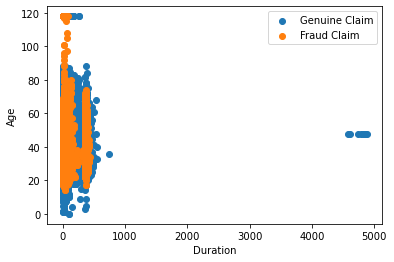

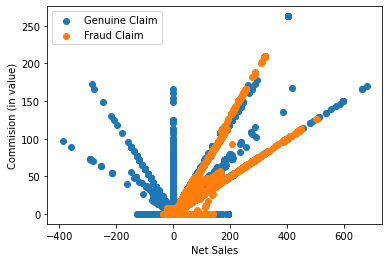

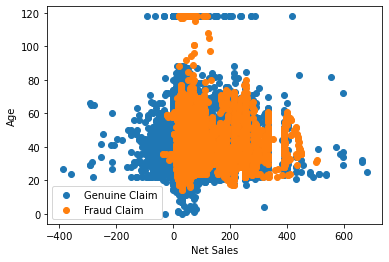

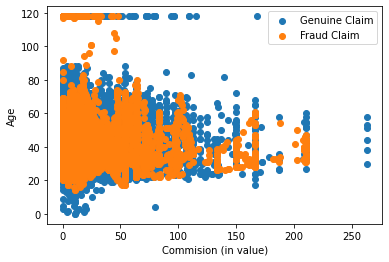

In [12]:
for ind_var_1 in range(len(continuous_vars)-1):
    for ind_var_2 in range(ind_var_1+1, len(continuous_vars)):
        var_1 = continuous_vars[ind_var_1]
        var_2 = continuous_vars[ind_var_2]
        
        seperability_plot(var_1, var_2)

In [15]:
if('Claim' + '_tagged' in train_data.columns):
    train_data = train_data.drop('Claim' + '_tagged', axis=1)
'Claim' + '_tagged' in train_data.columns

False

## Variable Transformation & Derived Variables

## Categorical Variables

In [16]:
categorical_vars = list(set(train_data.columns).difference(set(continuous_vars + ['ID', 'Claim'])))
categorical_vars

['Distribution Channel',
 'Agency',
 'Destination',
 'Product Name',
 'Agency Type']

### WOE - IV

The weight of Evidence is the ratio of log of %Non-Events and %Events.
Advantages of WOE

1. The categories having similar woe values(ratio) can be combined, as they have same behaviour w.r.t. the Target Variable

2. IV(Information Value) determines the importance of variables


In [17]:
help(woe.woe_iv)

Help on function woe_iv in module WOE_IV:

woe_iv(cat_var, data, events='Good', non_events='Bad', target='Listing_Type')



In [18]:
woe_iv_writer = pd.ExcelWriter(os.getcwd() + "/WOE_IV.xlsx")

for cat_var in categorical_vars:
    #1--> Represents Events
    #0--> Represents Non-Events
    woe_iv_df = woe.woe_iv(cat_var, train_data, 1, 0, 'Claim')
    
    #Write the distribution to the sheet
    woe_iv_df.to_excel(woe_iv_writer, sheet_name=cat_var)
    
#Close the writer for data to be written
woe_iv_writer.close()


## Grouping Categories

The categories having less than 5% of the contribution are clubbed into Others category 

### Minority Categories

In [19]:
#Product Name
others_product_name = ["Ticket Protector",
"Travel Cruise Protect",
"Gold Plan",
"Annual Gold Plan",
"Comprehensive Plan",
"Single Trip Travel Protect Gold",
"Annual Travel Protect Gold",
"24 Protect",
"Premier Plan",
"Single Trip Travel Protect Silver",
"Single Trip Travel Protect Platinum",
"Annual Travel Protect Silver",
"Individual Comprehensive Plan",
"Annual Travel Protect Platinum",
"Spouse or Parents Comprehensive Plan",
"Child Comprehensive Plan"
]

#Agency
others_agency = ["SSI",
"JWT",
"RAB",
"TST",
"KML",
"ART",
"CCR",
"TTW",
"CBH",
"CSR",
"ADM"
]

#Destination
others_destination = ["SPAIN",
"UNITED ARAB EMIRATES",
"SWITZERLAND",
"SRI LANKA",
"SOUTH AFRICA",
"NEPAL",
"NORWAY",
"LAO PEOPLE'S DEMOCRATIC REPUBLIC",
"IRELAND",
"ICELAND",
"DENMARK",
"MACAO",
"GREECE",
"PERU",
"PORTUGAL",
"AUSTRIA",
"BANGLADESH",
"FINLAND",
"TURKEY",
"RUSSIAN FEDERATION",
"CZECH REPUBLIC",
"SAUDI ARABIA",
"SWEDEN",
"CROATIA",
"BELGIUM",
"ISRAEL",
"MEXICO",
"MONGOLIA",
"POLAND",
"BRAZIL",
"PAKISTAN",
"MALDIVES",
"EGYPT",
"HUNGARY",
"ROMANIA",
"TANZANIA, UNITED REPUBLIC OF",
"ARGENTINA",
"KENYA",
"CYPRUS",
"MOROCCO",
"MALTA",
"BAHRAIN",
"QATAR",
"KAZAKHSTAN",
"FIJI",
"OMAN",
"UKRAINE",
"JORDAN",
"COLOMBIA",
"MAURITIUS",
"LUXEMBOURG",
"UZBEKISTAN",
"CHILE",
"ESTONIA",
"GEORGIA",
"SLOVENIA",
"AZERBAIJAN",
"GUAM",
"KUWAIT",
"BOLIVIA",
"COSTA RICA",
"VENEZUELA",
"TUNISIA",
"KYRGYZSTAN",
"LEBANON",
"VANUATU",
"LITHUANIA",
"ETHIOPIA",
"BELARUS",
"BERMUDA",
"BHUTAN",
"TURKMENISTAN",
"ZAMBIA"
]

### Majority Categories

List the categories within each categorical variable having more than 5 % count(i.e. less than 95% cummulative count)

In [25]:
'''
'Product Name',
'Agency',
'Destination'
'''

#Product Name
majority_product_name = list(set(train_data['Product Name']).\
                             difference(set(others_product_name)))

#Agency
majority_agency = list(set(train_data['Agency']).difference(set(others_agency)))

#Destination
majority_destination = list(set(train_data['Destination']).\
                            difference(set(others_destination)))

In [29]:
class GroupingCatVars():
    '''
    Group some of the categories belonging to 
    Destination, Agency and Product Name to "OTHERS"
    '''
    def __init__(self, data):
        self.data = data
        self.grouped_vars = [] #Store the newly created grouped variable
        
    def tag_others(self, cat_var, others_cat, majority_cat):
        '''
        Create a new grouped variable obtained vai 
        clubbing the less frequent categories.
        If a new category appeares in the unseen data then
        this category is tagged as "OTHERS"
        Input:-
        cat_var:- The categorical variable whose categories are to be grouped
        others_cat:- A list of categories that are to be tagged as "OTHERS"
        majority_cat:- A l
        '''
        self.data[cat_var + "_grouped"] = list(map(lambda cat: "OTHERS" if((cat in others_cat)\
                                                                           #Unseen category
                                                                           or ((cat not in others_cat)\
                                                                              and\
                                                                               (cat not in majority_cat)))
                                               else cat, self.data[cat_var]))
        
        #Update the list of grouped variables
        self.grouped_vars.append(cat_var + "_grouped")
        
    def driver(self):
        grouping_vars = ['Destination', 'Agency', 'Product Name']
        others_lists = [others_destination, others_agency, others_product_name]
        majority_lists = [majority_destination, majority_agency, majority_product_name]
        
        for var, others_list, majority_list in \
        zip(grouping_vars, others_lists, majority_lists):
            self.tag_others(var, others_list, majority_list)
        
        #Return the updated data with the grouped variables
        return self.grouped_vars

In [32]:
#Create an object of the GroupingCatVars class
grouping_cat_vars_train_obj = GroupingCatVars(train_data)
grouped_vars_train = grouping_cat_vars_train_obj.driver()

for var in ['Destination', 'Agency', 'Product Name']:
    print("# Categories in %s before grouping:- " %(var))
    print(len(set(train_data[var])))
    print("# Categories in %s after grouping:- " %(var))
    print(len(set(train_data[var + "_grouped"])))
    print("\n")
#train_data[grouped_vars].head()

# Categories in Destination before grouping:- 
97
# Categories in Destination after grouping:- 
25


# Categories in Agency before grouping:- 
16
# Categories in Agency after grouping:- 
6


# Categories in Product Name before grouping:- 
25
# Categories in Product Name after grouping:- 
10




In [33]:
#Create a copy of test data
#test_data_copy = test_data.copy()

In [34]:
#Create an object of the GroupingCatVars class
grouping_cat_vars_test_obj = GroupingCatVars(test_data)
grouped_vars_test = grouping_cat_vars_test_obj.driver()

for var in ['Destination', 'Agency', 'Product Name']:
    print("# Categories in %s before grouping:- " %(var))
    print(len(set(test_data[var])))
    print("# Categories in %s after grouping:- " %(var))
    print(len(set(test_data[var + "_grouped"])))
    print("\n")
#train_data[grouped_vars].head()

# Categories in Destination before grouping:- 
97
# Categories in Destination after grouping:- 
25


# Categories in Agency before grouping:- 
16
# Categories in Agency after grouping:- 
6


# Categories in Product Name before grouping:- 
25
# Categories in Product Name after grouping:- 
10




In [36]:
#['Destination_grouped', 'Agency_grouped', 'Product Name_grouped']
for grp_var in ['Destination_grouped', 'Agency_grouped', 'Product Name_grouped']:
    print(train_data.loc[0:5, grp_var])
    print(test_data.loc[0:5, grp_var])
    print("\n")

0    PHILIPPINES
1       MALAYSIA
2       THAILAND
3      HONG KONG
4       MALAYSIA
5       THAILAND
Name: Destination_grouped, dtype: object
0                    HONG KONG
1                    SINGAPORE
2                    SINGAPORE
3    TAIWAN, PROVINCE OF CHINA
4                    SINGAPORE
5                    SINGAPORE
Name: Destination_grouped, dtype: object


0    EPX
1    EPX
2    CWT
3    EPX
4    EPX
5    EPX
Name: Agency_grouped, dtype: object
0    EPX
1    EPX
2    C2B
3    EPX
4    C2B
5    C2B
Name: Agency_grouped, dtype: object


0                  Cancellation Plan
1                  Cancellation Plan
2    Rental Vehicle Excess Insurance
3           2 way Comprehensive Plan
4           2 way Comprehensive Plan
5           2 way Comprehensive Plan
Name: Product Name_grouped, dtype: object
0           Cancellation Plan
1    1 way Comprehensive Plan
2                 Bronze Plan
3    2 way Comprehensive Plan
4                 Silver Plan
5                 Bronze Plan
Na

## Encoding Categorical Variables

If fitting a classification algorithm there is no need for dropping the first category 
of the variable

In [ ]:
#One Hot Encoding
def OHE(data, cat_vars, train_test='train'):
    '''
    Input:-
    data:- The data set to be encoded
    cat_vars:- The list of categoricalvariables
    train_test:- The identifier for determining whether it's a train data or test data
    '''
    if(train_test=='train'):
        #Drop the first category if it's a train data
        encoded_data = pd.get_dummies(data[cat_vars], drop_first=True)
    else:
        #Don't drop first category for non-training data
        encoded_data = pd.get_dummies(data[cat_vars])
        
    encoded_features = list(set(encoded_data.columns).difference(set(cat_vars)))
    
    #Append the original features
    encoded_data = pd.concat([data, encoded_data], axis=1)
    
    #Return the encoded_data along-with the encoded features
    return encoded_data, encoded_features

encoded_data_train, encoded_features_train = OHE(train_data,categorical_vars)
encoded_data_test, encoded_features_test = OHE(train_data,categorical_vars, 'test')

In [53]:
list(map(len, [encoded_features_train, encoded_features_test]))

[40, 45]

In [56]:
#Categories dropped while encoding the train data

set(encoded_features_test).difference(set(encoded_features_train))

{'Agency Type_Airlines',
 'Agency_grouped_C2B',
 'Destination_grouped_AUSTRALIA',
 'Distribution Channel_Offline',
 'Product Name_grouped_1 way Comprehensive Plan'}

## Train and Test Data

In [64]:
#Tag the targets
target = 'Claim'
print("Count before tagging:- {}" .format(Counter(encoded_data_train[target])))

encoded_data_train[target + '_tagged'] = encoded_data_train[target].map({0:'Genuine Claim', 1:'Fraud Claim'})

print("Count after tagging:- {}" .format(Counter(encoded_data_train[target + '_tagged'])))

Count before tagging:- Counter({0: 43590, 1: 8720})
Count after tagging:- Counter({'Genuine Claim': 43590, 'Fraud Claim': 8720})


In [61]:
continuous_vars

['Duration', 'Net Sales', 'Commision (in value)', 'Age']

In [62]:
#Target variable
[var for var in train_data.columns if('claim' in var.lower())]

['Claim']

In [69]:
X_train = encoded_data_train[encoded_features_train + continuous_vars]
y_train = encoded_data_train[target]

X_test = encoded_data_test[encoded_features_train + continuous_vars]

## Modelling

In [83]:
class Modeling():
    
    def __init__(self, X_train, X_test, y_train, model, name_of_classifier):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        #self.y_test = y_test
        self.model = model
        self.clf_name = name_of_classifier
        
    def save_proba(self, probability, y, train_test):
        #Write the probability to a file
        probability_df = pd.DataFrame(probability, columns= ["Genuine", "Fraud"])
        
        if(train_test=='train'):
            probability_df["Actuals"] = y.tolist()
        
        probability_df.to_csv(os.getcwd() + "/Model Results/" + train_test + " Probabilities.csv")
    
    def auc_roc(self, X, y, train_test):
        predicted_probability = self.model.predict_proba(X)
        
        #Actuals for train data are present--> y_train
        if(train_test=='train'):
            #Save the probabilities
            self.save_proba(predicted_probability, y, train_test)
            
            fpr, tpr, _ = roc_curve(y,  predicted_probability[::,1])
            
            auc = roc_auc_score(y, predicted_probability[::,1])
            plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
            plt.legend(loc=4)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.savefig(os.getcwd() + "/Model Results/" + train_test + " AUC " + self.clf_name + ".png")
            plt.show()
            
        else:
            #Save the test probabilities
            self.save_proba(predicted_probability, y, train_test)
    
    def evaluate(self, CM, train_test):
        
        accuracy = CM.diagonal().sum()/CM.sum()
        precision = CM[1][1]/(CM[1][1] + CM[0][1])
        recall = CM[1][1]/(CM[1][1] + CM[1][0])
        f_measure = (2*precision*recall)/(precision+recall)
        print(train_test + " Data")
        print(CM)
        print("Accuracy:- {}\nPrecision:- {}\nRecall:- {}\nF-measure:- {}" \
              .format(accuracy,precision, recall, f_measure))
    
    def prediction(self):
        #Fit the model
        model = self.model.fit(self.X_train, self.y_train)
        
        #Predict on test set
        predicted_train = model.predict(self.X_train)
        predicted_test = model.predict(self.X_test)
        
        #Results
        result_train = pd.DataFrame({'Actual':self.y_train.ravel(), 'Predicted':predicted_train.ravel()},
        columns=['Actual','Predicted'])
        
        result_test = pd.DataFrame({'Predicted':predicted_test.ravel()},
        columns=['Predicted'])
        
        #Save the model
        joblib.dump(model, os.getcwd() + "/Model Results/" + self.clf_name + ".pkl")
        
        #Print the AUC_ROC curve
        self.auc_roc(self.X_train, self.y_train, "train")
        self.auc_roc(self.X_test, '', "test")
        
        #Evaluate the model
        CM_train = CM(self.y_train.ravel(), predicted_train.ravel(), labels=None, sample_weight=None)
        #CM_test = CM(self.y_test.ravel(), predicted_test.ravel(), labels=None, sample_weight=None)
        
        self.evaluate(CM_train, "train")
        #self.evaluate(CM_test, "test")

## Logistic Regression


### Without binning continuous variables

/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


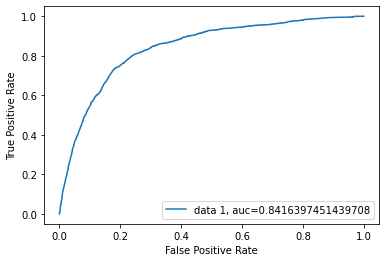

train Data
[[42036  1554]
 [ 6294  2426]]
Accuracy:- 0.8499713247944943
Precision:- 0.6095477386934673
Recall:- 0.2782110091743119
F-measure:- 0.38204724409448815


In [84]:
#X_train, X_test, y_train, model, name_of_classifier)
lr = LR()
logistic_model = Modeling(X_train, X_test, y_train, lr, "Logistic")
logistic_model.prediction()

In [92]:
#Counter(y_train)
event_rate = 8720*100/(8720+43590)
event_rate

16.66985280061174

In [93]:
os.getcwd()

'/home/shrikrishna/Downloads/Bharti AXA DS Test'

In [109]:
def get_predictions(file_path, thresh=0.1667):
    #print("Cut-off:- %.2f" %(thresh))
    probabilities = pd.read_csv(file_path)
    probabilities["Predicted"] = list(map(lambda prob: 1 if(prob>=thresh) 
                                         else 0, probabilities["Fraud"]))
    #Confusion Matrix
    CM_train = CM(probabilities["Actuals"].tolist(), probabilities["Predicted"].tolist())
    
    #print("Confusion Matrix:- \n{}" .format(CM_train))
    
    accuracy = CM_train.diagonal().sum()/CM_train.sum()
    precision = CM_train[1][1]/(CM_train[1][1] + CM_train[0][1])
    recall = CM_train[1][1]/(CM_train[1][1] + CM_train[1][0])
    f_measure = (2*precision*recall)/(precision+recall)
    
#     print("Accuracy:- {}\nPrecision:- {}\nRecall:- {}\nF-measure:- {}" \
#               .format(accuracy,precision, recall, f_measure))
    
    return accuracy, precision, recall, f_measure
    
logistic_prob_path = os.getcwd() + "/Model Results/Logistic Regression/train Probabilities.csv"
get_predictions(logistic_prob_path)

(0.7859873829095775,
 0.42157297674123834,
 0.7628440366972477,
 0.5430425731662516)

In [110]:
cut_off = 0
best_recall = 0
selected_cut_off = ''

#Store the results in a data frame
cut_off_values, accuracy_values = [], []
precision_values, recall_values = [], []
f_measure_values = []

while cut_off<1:
    accuracy, precision, recall, f_measure = get_predictions(logistic_prob_path, \
                                                             cut_off)
    cut_off_values.append(cut_off)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f_measure_values.append(f_measure)
    
    if(recall >= best_recall):
        best_recall = recall
        selected_cut_off = cut_off
        
    cut_off += 0.05   
    
#Create a data frame of results
logistic_results_df = pd.DataFrame({'Probability Cut Off': cut_off_values,\
                                    'Accuracy': accuracy_values, \
                                    'Precision': precision_values,\
                                    'Recall': recall_values,\
                                    'F1 Score': f_measure_values},\
                                  columns = ['Probability Cut Off', 'Accuracy',
                                            'Precision', 'Recall', 'F1 Score'])

logistic_results_df.to_csv(os.getcwd() + "/Model Results/Logistic Regression/Results Various Cut Off.csv")
best_recall, selected_cut_off 

(1.0, 0)

In [105]:
best_recall, selected_cut_off 

(1.0, 0)

In [82]:
TN = 42036
TP = 2426 
FP = 1554
FN = 6294
recall = TP/(TP+FN)
precision = TP/(TP+FP)
accuracy = (TP + TN)/(TP + TN + FP + FN)
f_measure = 2*precision*recall/(precision+recall)
print("Accuracy:- {}\nPrecision:- {}\nRecall:- {}\nF-measure:- {}"\
     .format(accuracy, precsion, recall, f_measure))

Accuracy:- 0.8499713247944943
Precision:- 0.6095477386934673
Recall:- 0.2782110091743119
F-measure:- 0.38204724409448815


## SVM

### Without binning continuous variables

In [88]:
#X_train, X_test, y_train, model, name_of_classifier)
'''
svm = svm.SVC()
logistic_model = Modeling(X_train, X_test, y_train, svm, "SVM")
logistic_model.prediction()
'''

AttributeError: predict_proba is not available when  probability=False

## Decision Tree

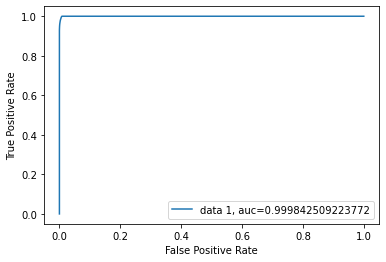

train Data
[[43446   144]
 [  165  8555]]
Accuracy:- 0.9940929076658382
Precision:- 0.9834463731463386
Recall:- 0.9810779816513762
F-measure:- 0.9822607497560136


In [89]:
#X_train, X_test, y_train, model, name_of_classifier)
dtc = DTC()
decision_tree_model = Modeling(X_train, X_test, y_train, dtc, "DTC")
decision_tree_model.prediction()

### Hyperparameter Tuning

In [91]:
def hyper_para_tuning(X, y, param_grid, model_obj, scoring_fun='f1_macro'):
    #Calculate the execution time
    start_time = timeit.time.time()
    
    grid = GCV(model_obj, param_grid, cv=5, n_jobs=1, scoring=scoring_fun)
    grid.fit(X, y)
    
    end_time = timeit.time.time()
    print("Execution time in minutes:- %.2f" %((end_time-start_time)/60))
    
    #Best parameters
    print("Best set of parameters:- {}\nBest Score:- {}" \
         .format(grid.best_estimator_, grid.best_score_))

In [ ]:
#Parameter Grid
param_grid = {"criterion": ['gini', 'entropy'],\
             "max_depth": list(range(1, 11)), \
             "min_samples_split": [2, 3, ]}